In [66]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [67]:
df = pd.read_csv("FIFA.csv")

In [68]:
df.head()

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Joined,Loaned From,Contract Valid Until,Height,Weight,Release Clause,Kit Number,Best Overall Rating
0,209658,L. Goretzka,27,https://cdn.sofifa.net/players/209/658/23_60.png,Germany,https://cdn.sofifa.net/flags/de.png,87,88,FC Bayern München,https://cdn.sofifa.net/teams/21/30.png,€91M,€115K,2312,Right,4.0,4.0,3.0,High/ Medium,Unique,Yes,"<span class=""pos pos28"">SUB","Jul 1, 2018",NaN,2026,189cm,82kg,€157M,8.0,NaN
1,212198,Bruno Fernandes,27,https://cdn.sofifa.net/players/212/198/23_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,86,87,Manchester United,https://cdn.sofifa.net/teams/11/30.png,€78.5M,€190K,2305,Right,3.0,3.0,4.0,High/ High,Unique,Yes,"<span class=""pos pos15"">LCM","Jan 30, 2020",NaN,2026,179cm,69kg,€155M,8.0,NaN
2,224334,M. Acuña,30,https://cdn.sofifa.net/players/224/334/23_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,85,85,Sevilla FC,https://cdn.sofifa.net/teams/481/30.png,€46.5M,€46K,2303,Left,2.0,3.0,3.0,High/ High,Stocky (170-185),No,"<span class=""pos pos7"">LB","Sep 14, 2020",NaN,2024,172cm,69kg,€97.7M,19.0,NaN
3,192985,K. De Bruyne,31,https://cdn.sofifa.net/players/192/985/23_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,91,91,Manchester City,https://cdn.sofifa.net/teams/10/30.png,€107.5M,€350K,2303,Right,4.0,5.0,4.0,High/ High,Unique,Yes,"<span class=""pos pos13"">RCM","Aug 30, 2015",NaN,2025,181cm,70kg,€198.9M,17.0,NaN
4,224232,N. Barella,25,https://cdn.sofifa.net/players/224/232/23_60.png,Italy,https://cdn.sofifa.net/flags/it.png,86,89,Inter,https://cdn.sofifa.net/teams/44/30.png,€89.5M,€110K,2296,Right,3.0,3.0,3.0,High/ High,Normal (170-),Yes,"<span class=""pos pos13"">RCM","Sep 1, 2020",NaN,2026,172cm,68kg,€154.4M,23.0,NaN


In [69]:
df.shape

(17660, 29)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17660 entries, 0 to 17659
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        17660 non-null  int64  
 1   Name                      17660 non-null  object 
 2   Age                       17660 non-null  int64  
 3   Photo                     17660 non-null  object 
 4   Nationality               17660 non-null  object 
 5   Flag                      17660 non-null  object 
 6   Overall                   17660 non-null  int64  
 7   Potential                 17660 non-null  int64  
 8   Club                      17449 non-null  object 
 9   Club Logo                 17660 non-null  object 
 10  Value                     17660 non-null  object 
 11  Wage                      17660 non-null  object 
 12  Special                   17660 non-null  int64  
 13  Preferred Foot            17660 non-null  object 
 14  Intern

Our target variable is 'Overall' which is the total rating of the players. So let's promptly remove the features that won't be useful for our prediction.

- Initial Observations and Cleaning Plan

    - Unnecessary Columns
        - Photo, Flag, Club Logo: These URLs are irrelevant for analysis.
        - Best Overall Rating: Only 21 non-null values out of 17,660 → Drop.

    - Missing Values
        - Club, Body Type, Real Face, Position, Contract Valid Until: Some missing values.
        - Loaned From: Mostly empty, could be removed.
        - Joined: Many missing values, might need imputation.
        - Release Clause: Some missing values.

    - Data Type Issues
        - Value, Wage, Release Clause: Stored as strings with "€" → Convert to numerical.
        - Height & Weight: Convert "cm" and "kg" to numerical values.
        - Contract Valid Until: Convert to datetime.

    - Potential Fixes
        - Standardize column names.
        - Convert categorical columns into consistent values.
        - Handle missing values using mode/median where applicable.

In [71]:
df.drop(columns=['ID', 'Name', 'Photo', 'Flag', 'Club Logo', 'Loaned From','Best Overall Rating'], inplace=True)

In [72]:
df['Height'] = df['Height'].str.replace('cm','').astype(float)
df['Weight'] = df['Weight'].str.replace('kg','').astype(float)

In [73]:
def fix_currency(value):
    if isinstance(value, str):
        value = value.replace('€', '').replace('M','e6').replace('K','e3')
        return eval(value) if value else None
    return value

In [74]:
df['Value'] = df['Value'].apply(fix_currency)
df['Wage'] = df['Wage'].apply(fix_currency)
df['Release Clause'] = df['Release Clause'].apply(fix_currency)

In [75]:
df["Contract Valid Until"] = pd.to_datetime(df["Contract Valid Until"], errors="coerce")

In [76]:
cols_temp = ['Club', 'Body Type', 'Real Face', 'Position', 'Joined', 'Contract Valid Until']
for i in cols_temp:
    df[i] = df[i].fillna(df[i].mode()[0])

In [77]:
df['Release Clause'] = df['Release Clause'].fillna(df['Release Clause'].median())

In [78]:
df['Kit Number'] = df['Kit Number'].fillna(0)

In [79]:
df.isna().sum()

Age                         0
Nationality                 0
Overall                     0
Potential                   0
Club                        0
Value                       0
Wage                        0
Special                     0
Preferred Foot              0
International Reputation    0
Weak Foot                   0
Skill Moves                 0
Work Rate                   0
Body Type                   0
Real Face                   0
Position                    0
Joined                      0
Contract Valid Until        0
Height                      0
Weight                      0
Release Clause              0
Kit Number                  0
dtype: int64

In [80]:
df['Position'] = df['Position'].str.replace(r"<.*?>","",regex=True)

In [81]:
df = df.rename({'Preferred Foot':'Preferred_Foot',
                'International Reputation':'International_Reputation',
                'Weak Foot':'Weak_Foot',
                'Skill Moves':'Skill_Moves',
                'Work Rate':'Work_Rate',
                'Body Type':'Body_Type',
                'Real Face':'Real_Face',
                'Contract Valid Until':'Contract_Valid_Until',
                'Release Clause':'Release_Clause',
                'Kit Number':'Kit_Number'}, axis=1)

In [82]:
df.duplicated().sum()

np.int64(0)

Fixed almost all the early issues with the dataset. Now will move forward with further analysis and preprocessing. Outlier detection and removal will be our next step.

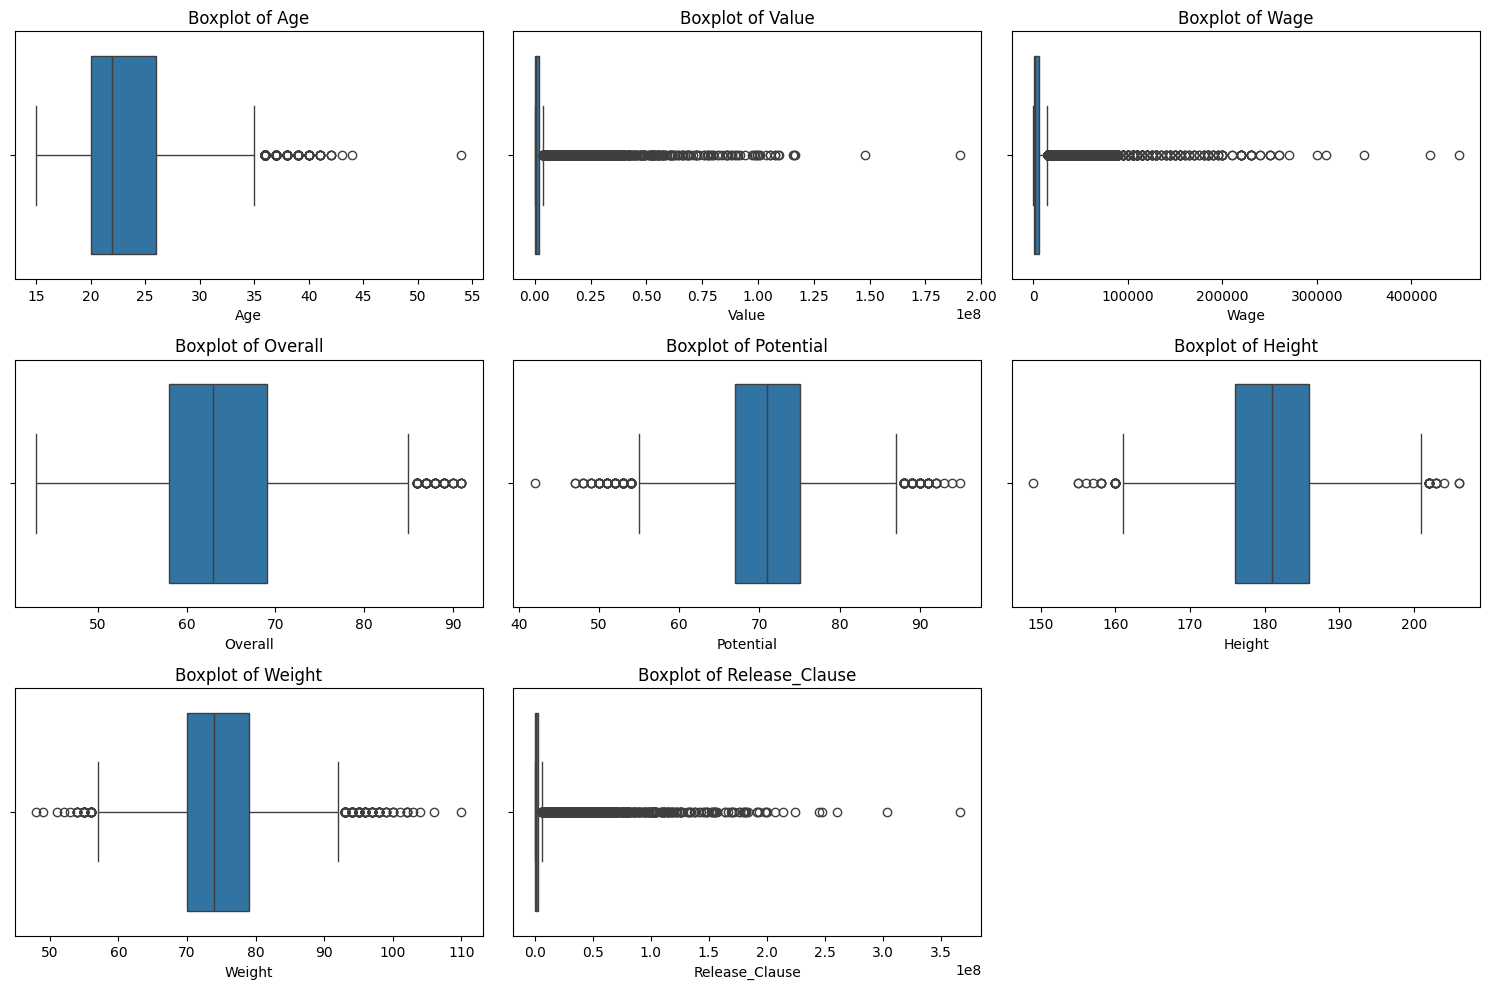

In [83]:
numerical_cols = ["Age", "Value", "Wage", "Overall", "Potential", "Height", "Weight", "Release_Clause"]

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

- Outlier Detection Insights

    - Value, Wage, and Release Clause show extreme outliers due to star players with massive salaries.
    - Height and Weight have some unusually high values but are expected in football.
    - Age has some very high values, likely due to veteran players.
    - Overall and Potential appear mostly normal, but a few players might have extreme ratings.

In [84]:
def remove_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [85]:
cols_temp = ['Value', 'Wage', 'Release_Clause', 'Weight']
for i in cols_temp:
    df = remove_outliers_iqr(df,i)

We used IQR for Weight because it had extreme outliers, likely due to incorrect or unusually high values. Height, however, showed a natural distribution with fewer extreme values, making IQR less necessary.

We didn't apply IQR on Age because veteran players (high age) are valid and not erroneous outliers. However, if we find unrealistic values (e.g., age > 50 in a professional league), we should reconsider.

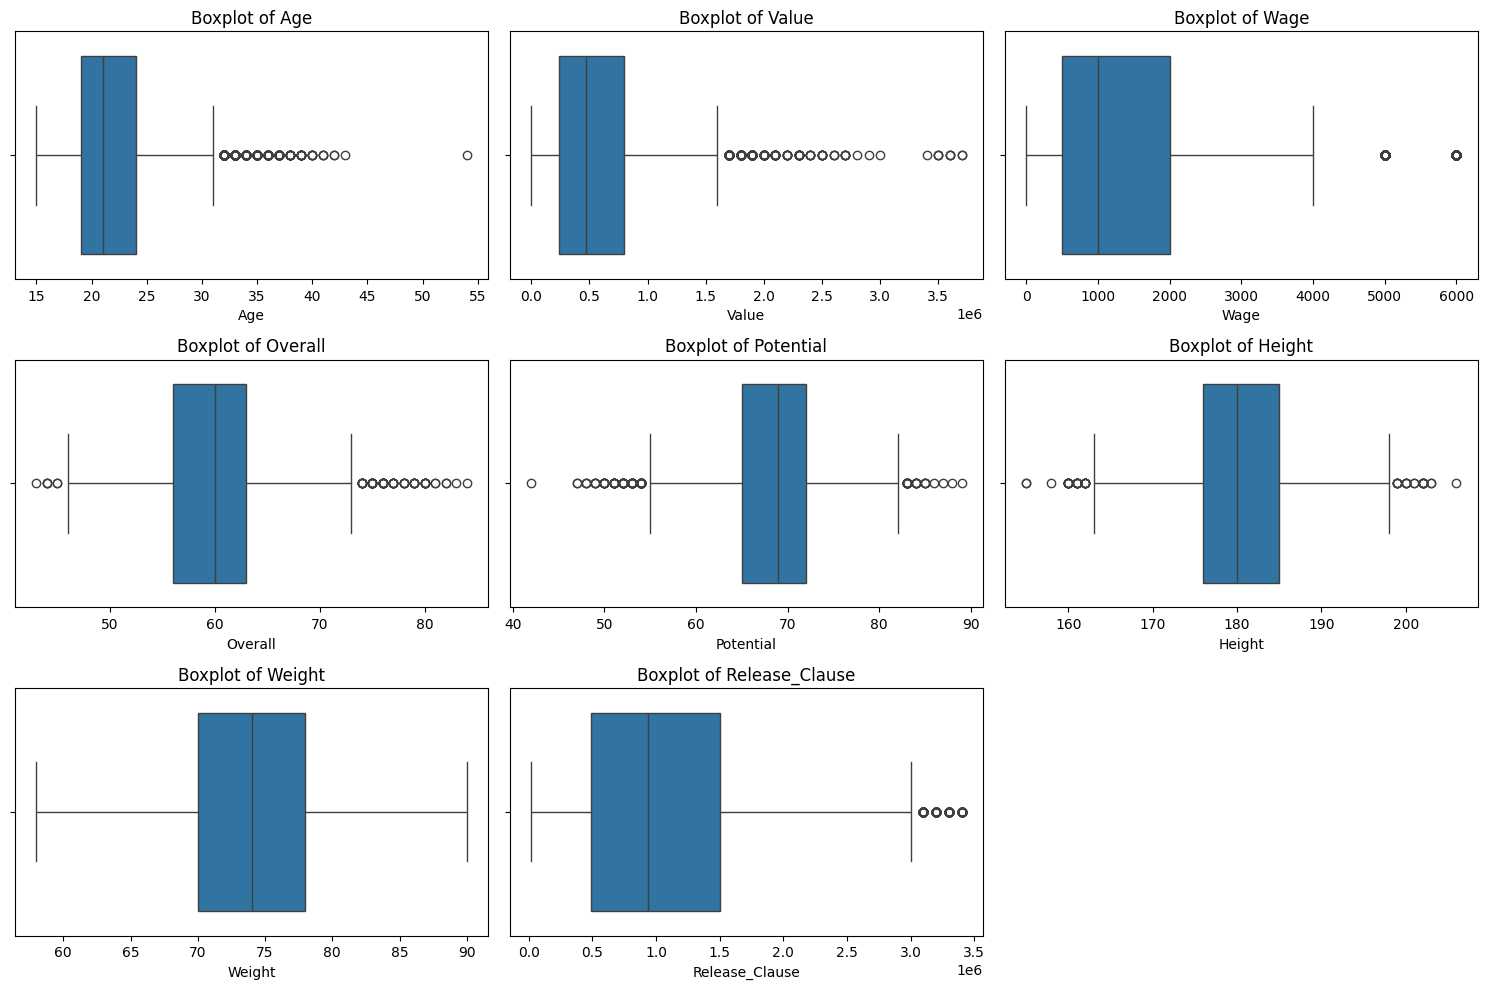

In [86]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

In [53]:
df.describe()

,Age,Overall,Potential,Value,Wage,Special,International_Reputation,Weak_Foot,Skill_Moves,Contract_Valid_Until,Height,Weight,Release_Clause,Kit_Number
count,17660.000000,17660.000000,17660.000000,1.766000e+04,17660.000000,17660.000000,17660.000000,17660.000000,17660.000000,17660,17660.000000,17660.000000,1.766000e+04,17660.000000
mean,23.127746,63.369592,70.981200,2.739788e+06,8189.807475,1537.915855,1.106285,2.900340,2.297169,2023-04-14 13:10:56.398641152,180.893431,74.326161,5.110592e+06,24.988335
min,15.000000,43.000000,42.000000,0.000000e+00,0.000000,749.000000,1.000000,1.000000,1.000000,2007-01-01 00:00:00,149.000000,48.000000,2.000000e+04,0.000000
25%,20.000000,58.000000,67.000000,3.250000e+05,550.000000,1387.000000,1.000000,3.000000,2.000000,2022-01-01 00:00:00,176.000000,70.000000,6.420000e+05,11.000000
50%,22.000000,63.000000,71.000000,7.000000e+05,2000.000000,1548.000000,1.000000,3.000000,2.000000,2023-01-01 00:00:00,181.000000,74.000000,1.300000e+06,22.000000
75%,26.000000,69.000000,75.000000,1.725000e+06,6000.000000,1727.000000,1.000000,3.000000,3.000000,2024-01-01 00:00:00,186.000000,79.000000,3.025000e+06,32.000000
max,54.000000,91.000000,95.000000,1.905000e+08,450000.000000,2312.000000,5.000000,5.000000,5.000000,2031-01-01 00:00:00,206.000000,110.000000,3.667000e+08,99.000000
std,4.639821,8.036268,6.529836,7.841276e+06,20476.733001,285.893809,0.407021,0.663523,0.754264,NaN,6.962486,6.982741,1.507026e+07,19.167499


In [54]:
df.describe(include=object)

,Nationality,Club,Preferred_Foot,Work_Rate,Body_Type,Real_Face,Position,Joined
count,17660,17660,17660,17660,17660,17660,17660,17660
unique,161,926,2,10,10,2,29,1855
top,England,Manchester United,Right,Medium/ Medium,Normal (170-185),No,SUB,"Jul 1, 2021"
freq,1531,277,13651,10049,6286,15614,7462,2012
